## Analysis of feature behaviour with `XGBRegressor`

- **Data**:
    - All the events including both pions and muons
- **Model type**: 
    - Regressor 
- **Engineered features**
    - `total_in_time_hits`: total number of in-time hits in each event 
    - `x_aligned_min`: minimum hit position realigned by subtracting track position x in each event
    - `x_aligned_max`: maximum hit position realigned by subtracting track position x in each event
    - `y_aligned_min`: minimum hit position realigned by subtracting track position y in each event
    - `y_aligned_max`: maximum hit position realigned by subtracting track position y in each event
    - `x_aligned_width`: maximum hit position x minus minimum hit position x in each event
    - `y_aligned_witdh`: maximum hit position y minus minimum hit position y in each event `
    - `hit_distance_min`: minimum distance between hit position and track position in each event 
    - `hit_distance_max`: maximum distance between hit position and track position in each event 
    - `hit_distance_mean`: mean distance between hit position and track position in each event 
    - `hit_distance_median`: median distance between hit position and track position in each event
    - `hit_distance_q25`: 25% percentile distance between hit position and track position in each event
    - `hit_distance_q75`: 75% percentile distance between hit position and track position in each event
    - `hit_distance_rms`: root mean squared distance between hit position and track position in each event 
    - `hull_area`: hull area of the convex hull
    - `hull_diameter`: the longest line among all the points
    - `hull_diff_width_diameter`: the absolute difference between `hull_diameter` and `hull_width`
    - `hull_width`: closest distance of the parallel lines that encloses all points

- **Preprocessing**:
    - Only the in-time hits where delta <= 0.5 are included 


    

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
import glob
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [2]:
import pyarrow 

In [3]:
df = pd.read_parquet('../../data/events_with_hit_features_[cut_off_time=0.5].parquet')

In [8]:
df_selected = df

### Fitting

In [232]:
train_df, test_df = train_test_split(df_selected, random_state=42)

In [165]:
X_train = train_df.iloc[:, 1:19]
y_train = train_df['ring_radius_cal']
X_test = test_df.iloc[:, 1:19]
y_test = test_df['ring_radius_cal']

In [112]:
xgb_reg = xgb.XGBRegressor()

In [15]:
reg_metrics = ['neg_root_mean_squared_error', 'r2']

In [16]:
from sklearn.model_selection import cross_val_score, cross_validate, RandomizedSearchCV

In [233]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Feature importance

In [234]:
pd.DataFrame({'features': xgb_reg.feature_names_in_, 'importance': xgb_reg.feature_importances_}).sort_values(by='importance', ascending=False)

,features,importance
10,hit_distance_median,0.922987
13,hit_distance_rms,0.015987
11,hit_distance_q25,0.013100
12,hit_distance_q75,0.010223
5,y_aligned_max,0.007740
2,x_aligned_max,0.004106
8,hit_distance_max,0.003516
1,x_aligned_min,0.003410
15,hull_diameter,0.003220
9,hit_distance_mean,0.002417


### Computing residuals

In [20]:
ypred = xgb_reg.predict(X_test)

In [21]:
pred_df = pd.DataFrame(ypred, y_test).reset_index()
pred_df.columns=['theoretical_radius', 'predicted_radius']

In [22]:
pred_df

,theoretical_radius,predicted_radius
0,185.887466,184.483902
1,187.168259,186.736954
2,179.363281,181.612076
3,182.011658,181.253036
4,186.025742,185.137619
...,...,...
592274,186.015732,184.033615
592275,174.283478,174.762604
592276,188.395416,186.920029
592277,184.343750,182.627533


In [24]:
pred_df['residual'] = pred_df['theoretical_radius'] - pred_df['predicted_radius']

Text(0, 0.5, 'Residuals')

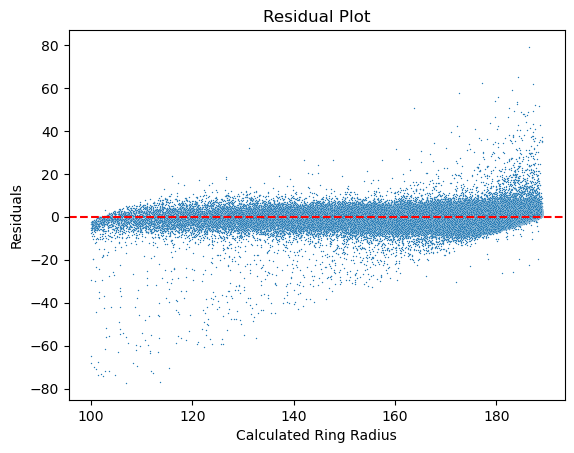

In [25]:
sns.scatterplot(data=pred_df, x='theoretical_radius', y='residual', s=1)

plt.axhline(y=0, color='red', linestyle='--')

plt.title('Residual Plot')
plt.xlabel('Calculated Ring Radius')
plt.ylabel('Residuals')

In [26]:
pred_df

,theoretical_radius,predicted_radius,residual
0,185.887466,184.483902,1.403564
1,187.168259,186.736954,0.431305
2,179.363281,181.612076,-2.248795
3,182.011658,181.253036,0.758621
4,186.025742,185.137619,0.888123
...,...,...,...
592274,186.015732,184.033615,1.982117
592275,174.283478,174.762604,-0.479126
592276,188.395416,186.920029,1.475388
592277,184.343750,182.627533,1.716217


In [30]:
pred_df['momentum'] = test_df.reset_index()['track_momentum']

In [31]:
pred_df

,theoretical_radius,predicted_radius,residual,momentum
0,185.887466,184.483902,1.403564,42.997105
1,187.168259,186.736954,0.431305,50.454266
2,179.363281,181.612076,-2.248795,27.957302
3,182.011658,181.253036,0.758621,31.898188
4,186.025742,185.137619,0.888123,43.644939
...,...,...,...,...
592274,186.015732,184.033615,1.982117,43.597008
592275,174.283478,174.762604,-0.479126,23.337013
592276,188.395416,186.920029,1.475388,63.245411
592277,184.343750,182.627533,1.716217,37.318935


### Comparison with SOTA

In [34]:
res_comp = df_selected[['ring_radius_cal', 'ring_radius']]

In [35]:
res_comp['radius_pred'] = xgb_reg.predict(df_selected.iloc[:, 1:19])

/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_44932/289616146.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_comp['radius_pred'] = xgb_reg.predict(df_selected.iloc[:, 1:19])


In [36]:
res_comp['res_model'] = res_comp['ring_radius_cal'] - res_comp['radius_pred']
res_comp['res_sota'] = res_comp['ring_radius_cal'] - res_comp['ring_radius']

/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_44932/4182022239.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_comp['res_model'] = res_comp['ring_radius_cal'] - res_comp['radius_pred']
/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_44932/4182022239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_comp['res_sota'] = res_comp['ring_radius_cal'] - res_comp['ring_radius']


In [37]:
res_comp = res_comp.reset_index()

In [42]:
res_comp[['momentum', 'class']] = df_selected.reset_index()[['track_momentum', 'class']]

[(95.0, 200.0)]

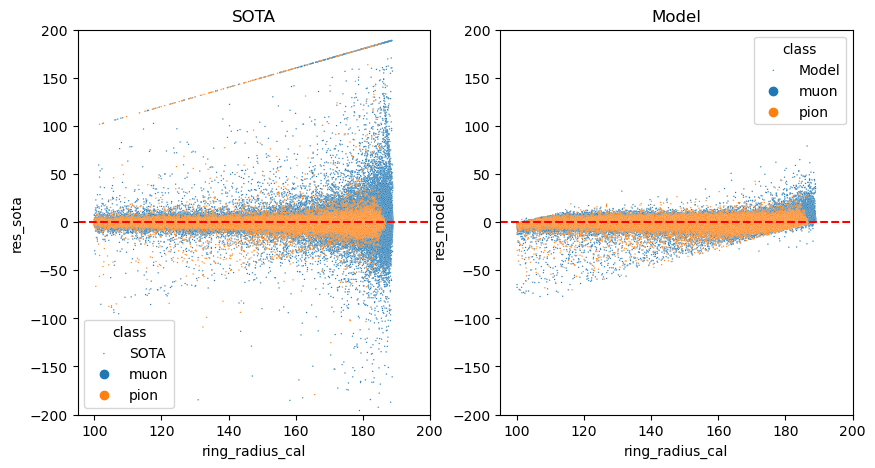

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(data=res_comp, x='ring_radius_cal', y='res_sota', s=1, hue='class', label='SOTA', ax=axes[0])
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title('SOTA')
axes[0].set(ylim = (-200, 200))
axes[0].set(xlim = (95, 200))


sns.scatterplot(data=res_comp, x='ring_radius_cal', y='res_model', s=1, hue='class', label='Model', ax=axes[1])
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_title('Model')
axes[1].set(ylim = (-200, 200))
axes[1].set(xlim = (95, 200))

In [115]:
res_comp['max_calc_diff'] = res_comp['ring_radius_cal'] - res_comp['ring_radius_cal'].max()

In [116]:
res_comp

,level_0,index,ring_radius_cal,ring_radius,radius_pred,res_model,res_sota,momentum,class,max_calc_diff
0,0,0,173.410156,172.410950,171.478516,1.931641,0.999207,22.761024,muon,-15.624924
1,1,1,174.660522,175.251694,174.277542,0.382980,-0.591171,23.600529,muon,-14.374557
2,2,2,155.299332,155.040802,152.685394,2.613937,0.258530,16.275131,muon,-33.735748
3,3,3,184.035400,185.832642,183.959869,0.075531,-1.797241,36.436443,muon,-4.999680
4,4,4,156.473602,158.641846,162.140076,-5.666473,-2.168243,16.525362,muon,-32.561478
...,...,...,...,...,...,...,...,...,...,...
2369110,2369110,2376022,174.585281,175.371704,174.264511,0.320770,-0.786423,31.104301,pion,-14.449799
2369111,2369111,2376023,176.125702,178.343094,180.891251,-4.765549,-2.217392,32.657063,pion,-12.909378
2369112,2369112,2376024,148.410736,148.395798,150.100266,-1.689529,0.014938,19.860395,pion,-40.624344
2369113,2369113,2376025,172.438187,175.335617,170.927780,1.510406,-2.897430,29.285913,pion,-16.596893


### Plot showing residual and `max_cal_diff` 
- `max_cal_diff` is calculated by subracting the maximum value of `ring_radius_cal` from `ring_radius_cal`
- The difference between calculated ring radius of each example and the maximum value is calculated, shown as the red line
- Points above this line indicate that the predicted radius is smaller than the max calculated ring radius


Text(0, 0.5, 'Residuals')

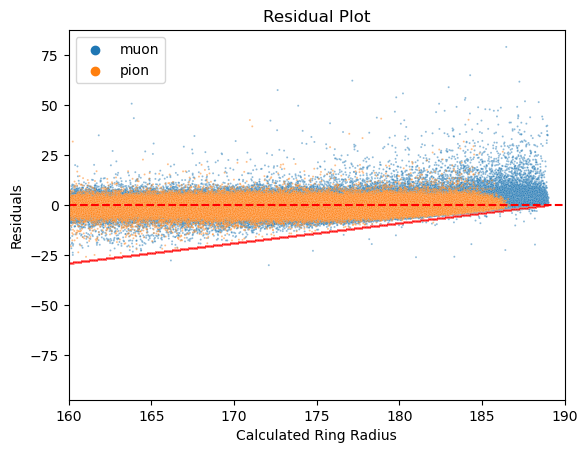

In [117]:
sns.scatterplot(data=res_comp, x='ring_radius_cal', y='res_model', s=2, alpha = 0.5, hue='class')
g = sns.scatterplot(data=res_comp, x='ring_radius_cal', y='max_calc_diff', s=1, color='red', alpha=0.2)
plt.axhline(y=0, color='red', linestyle='--')
g.set_xlim(160, 190)
plt.title('Residual Plot')
plt.xlabel('Calculated Ring Radius')
plt.ylabel('Residuals')

In [123]:
res_comp.query('max_calc_diff > res_model')['class'].value_counts()

muon    85
pion     2
Name: class, dtype: int64

### SHAP analysis 

- SHAP (SHapley Additive exPlanations) analysis is used to explain the predictions of machine learning models
- It provides a way to understand the contribution of each feature to the model's output.
- SHAP values represent the marginal contribution of a feature to the expected prediction compared to a baseline prediction.


In [124]:
import shap

/Users/Jialing/opt/miniconda3/envs/591/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [166]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [168]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [169]:
xgb_explainer = shap.TreeExplainer(xgb_reg)
train_xgb_shap_values = xgb_explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [170]:
test_xgb_shap_values = xgb_explainer.shap_values(X_test)

In [171]:
shap.initjs()

In [172]:
ypred = xgb_reg.predict(X_test)

In [173]:
pred_df = pd.DataFrame(ypred, y_test).reset_index()
pred_df.columns=['theoretical_radius', 'predicted_radius']

In [174]:
pred_df

,theoretical_radius,predicted_radius
0,185.887466,184.483902
1,187.168259,186.736954
2,179.363281,181.612076
3,182.011658,181.253036
4,186.025742,185.137619
...,...,...
592274,186.015732,184.033615
592275,174.283478,174.762604
592276,188.395416,186.920029
592277,184.343750,182.627533


In [175]:
pred_df['residual'] = pred_df['theoretical_radius'] - pred_df['predicted_radius']

In [177]:
pred_df['max_calc_diff'] = pred_df['theoretical_radius'] - pred_df['theoretical_radius'].max()

In [205]:
feature_names = X_train.columns

### Showing the SHAP values using one example (4785)

In [207]:
pd.DataFrame(
    test_xgb_shap_values[4785, :],
    index=feature_names,
    columns=["SHAP values"],
)

,SHAP values
total_in_time_hits,2.936392
x_aligned_min,4.166733
x_aligned_max,1.001810
x_aligned_width,0.319132
y_aligned_min,0.374040
y_aligned_max,2.106480
y_aligned_width,1.835307
hit_distance_min,1.095935
hit_distance_max,1.030221
hit_distance_mean,1.871357


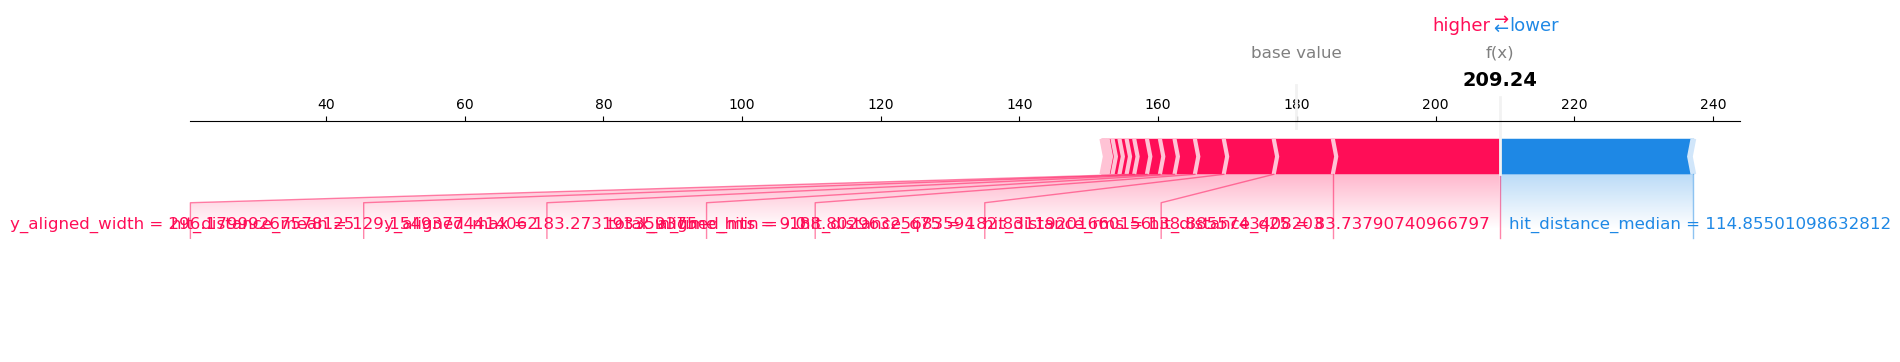

In [213]:
shap.force_plot(
    xgb_explainer.expected_value,
    test_xgb_shap_values[4785, :], # SHAP values associated with the example we want to explain
    X_test.iloc[4785, :], # Feature vector of the example 
    matplotlib=True,
)

### Global SHAP analysis

In [210]:
values = np.abs(train_xgb_shap_values).mean(0) 
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)

,SHAP
hit_distance_median,6.000538
hit_distance_q25,0.796071
hit_distance_q75,0.468452
y_aligned_max,0.461991
hull_diameter,0.227926
x_aligned_max,0.167014
hit_distance_mean,0.166260
total_in_time_hits,0.142319
hull_area,0.141895
hit_distance_min,0.123867


### SHAP summary plot on train set

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


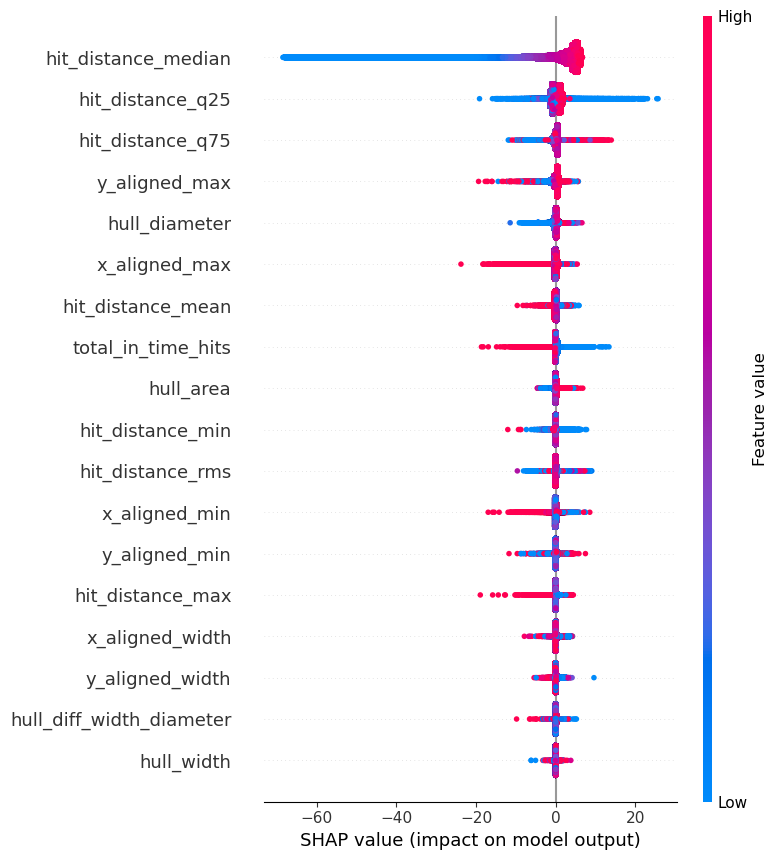

In [211]:
shap.summary_plot(train_xgb_shap_values, X_train)

### SHAP summary plot on test set

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


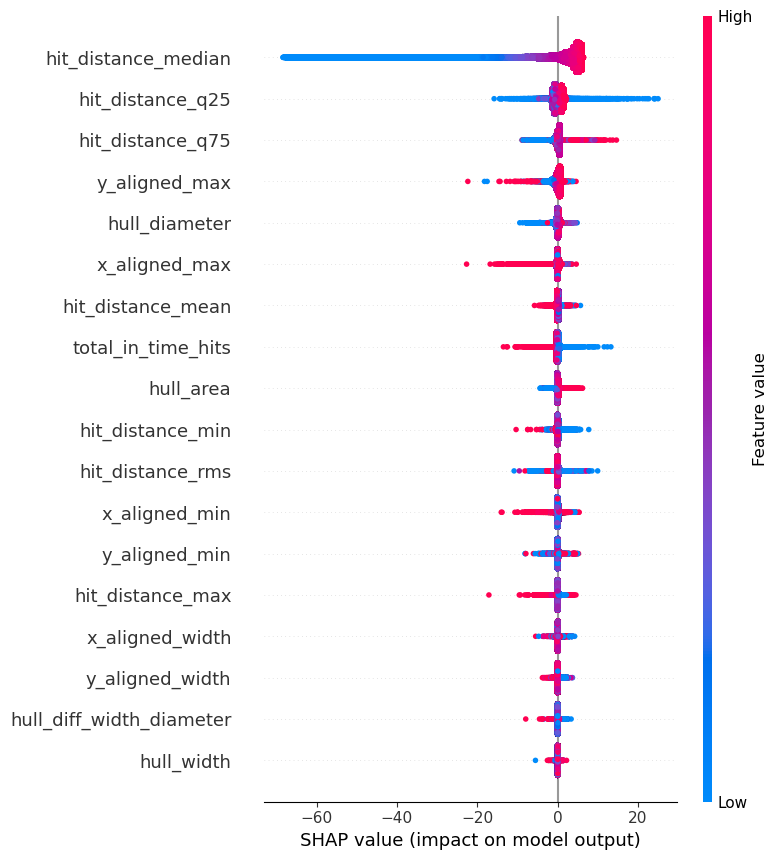

In [216]:
shap.summary_plot(test_xgb_shap_values, X_test)

- Features are ranked based on their importance, from top to bottom

- The bar on the right-hand-side indicates feature values (e.g., value of hit_distance_median)

- The x-axis indicates SHAP value:
    - A negative SHAP value indicates the feature contributes negatively to the prediction
    - A positive SHAP value indicates the feature contributes positively to the prediction


### Plotting predicted and theoretical radius vs. track momentum

- Green lines: theoretical ring radius vs. track momentum 
- Blue points: predicted ring radius vs. track momentum for muons
- Orange points: predicted ring radius vs. track momentum for pions
- Can see that the model underestimates radius for muons for momentum > 57 GeV/c


#### XGBRegressor model

(165.0, 195.0)

/Users/Jialing/opt/miniconda3/envs/591/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/Jialing/opt/miniconda3/envs/591/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


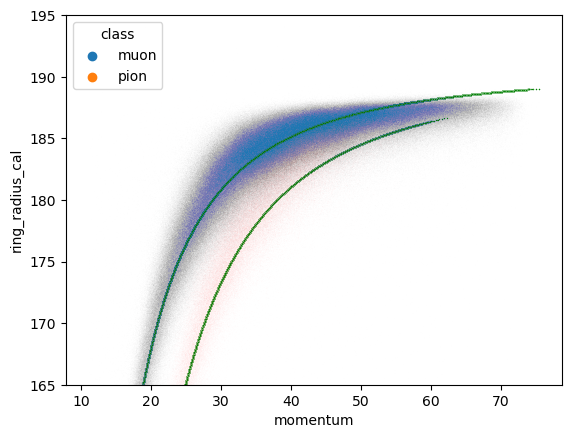

In [47]:
sns.scatterplot(data=res_comp, x='momentum', y='ring_radius_cal', color ='green', s=1)
g = sns.scatterplot(data=res_comp, x='momentum', y='radius_pred', s=1, hue='class', alpha=0.005)

g.set_ylim(165, 195)


#### SOTA model

(165.0, 195.0)

/Users/Jialing/opt/miniconda3/envs/591/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/Jialing/opt/miniconda3/envs/591/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


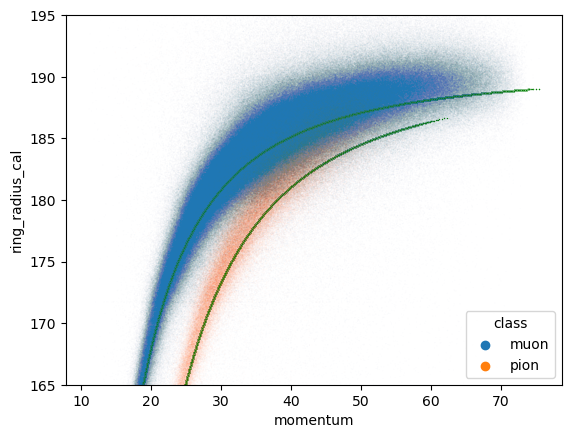

In [48]:
sns.scatterplot(data=res_comp, x='momentum', y='ring_radius_cal', color='green', s=1)
h = sns.scatterplot(data=res_comp, x='momentum', y='ring_radius', s=1, hue='class', alpha=0.01)
h.set_ylim(165, 195)

#### Plotting predicted radius vs. calculated ring radius

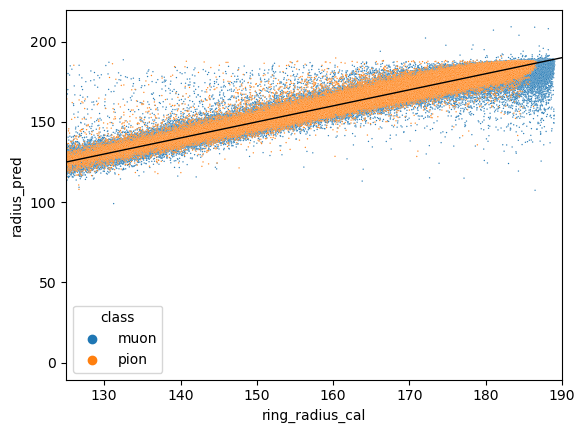

In [49]:
g = sns.scatterplot(data = res_comp, x = 'ring_radius_cal', y = 'radius_pred', hue='class', s=1)
g.set_xlim(125, 190)

plt.plot([0, 190], [0, 190], color='black', linestyle='-', linewidth=1)

(170.0, 190.0)

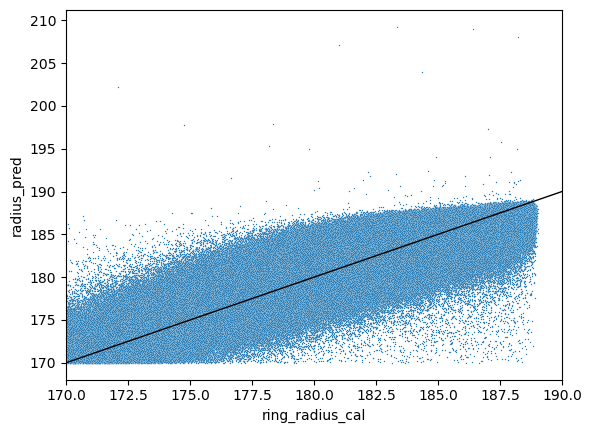

In [50]:
g = sns.scatterplot(data = res_comp.query('radius_pred >=170 & `class`=="muon"'), x = 'ring_radius_cal', y = 'radius_pred', s=1)
plt.plot([170, 190], [170, 190], color='black', linestyle='-', linewidth=1)
g.set_xlim(170, 190)

In [51]:
df_selected['ring_radius_cal'].max()

189.03508

In [53]:
bins = range(100, 191, 5)
labels = [f'{i}-{i+10}' for i in range(100, 186, 5)]
df_selected['radius_bin'] = pd.cut(df_selected['ring_radius_cal'], bins=bins, labels=labels)

/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_44932/4023889918.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['radius_bin'] = pd.cut(df_selected['ring_radius_cal'], bins=bins, labels=labels)


#### Plotting hit_distance_median` vs. calculated ring radius

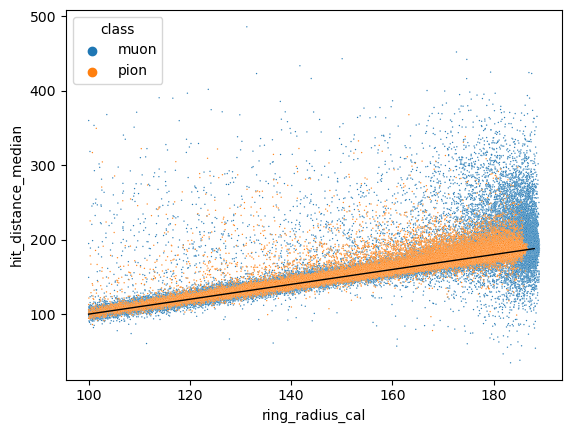

In [58]:
sns.scatterplot(data = df_selected, x = 'ring_radius_cal', y = 'hit_distance_median', hue='class', s=1)

plt.plot([100, 188], [100, 188], color='black', linestyle='-', linewidth=1)

Text(37.597222222222214, 0.5, 'Median hit radius')

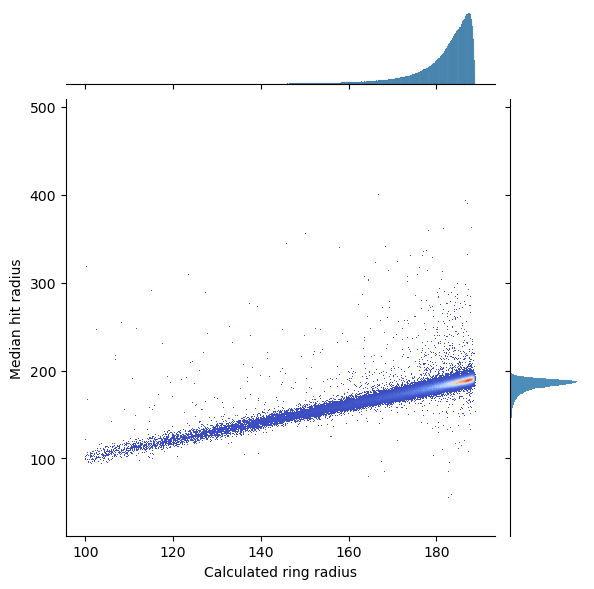

In [56]:
g = sns.jointplot(data = df_selected, x = 'ring_radius_cal', y = 'hit_distance_median', kind='hist', cmap='coolwarm')

plt.xlabel('Calculated ring radius')
plt.ylabel('Median hit radius')

### Testing model with `hit_distance_median` only as feature 

In [59]:
X_train_selected = X_train.drop(columns=['hit_distance_median'])
X_test_selected = X_test.drop(columns=['hit_distance_median'])

In [60]:
xgb_reg.fit(X_train_selected, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [61]:
pd.DataFrame({'features': xgb_reg.feature_names_in_, 'importance': xgb_reg.feature_importances_}).sort_values(by='importance', ascending=False)

,features,importance
11,hit_distance_q75,0.532684
12,hit_distance_rms,0.310180
10,hit_distance_q25,0.094011
5,y_aligned_max,0.019515
2,x_aligned_max,0.008658
8,hit_distance_max,0.005458
14,hull_diameter,0.004972
7,hit_distance_min,0.004449
1,x_aligned_min,0.003809
9,hit_distance_mean,0.003808


In [62]:
y_pred_selected = xgb_reg.predict(X_test_selected)

pred_selected_df = pd.DataFrame(y_pred_selected, y_test).reset_index()
pred_selected_df.columns=['theoretical_radius', 'predicted_radius']
pred_selected_df['residual'] = pred_selected_df['theoretical_radius'] - pred_selected_df['predicted_radius']

Text(0, 0.5, 'Residuals')

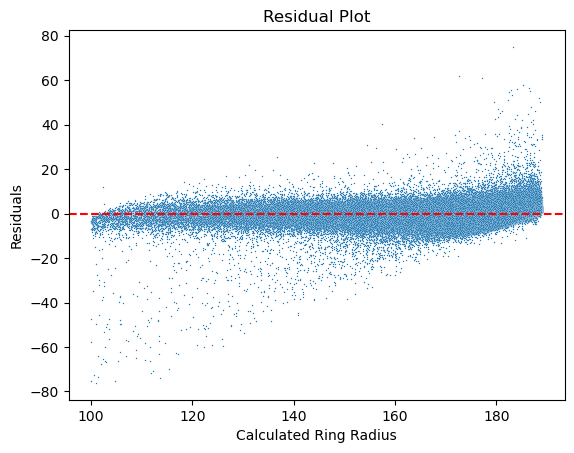

In [63]:
sns.scatterplot(data=pred_selected_df, x='theoretical_radius', y='residual', s=1)
plt.axhline(y=0, color='red', linestyle='--')

plt.title('Residual Plot')
plt.xlabel('Calculated Ring Radius')
plt.ylabel('Residuals')

In [77]:
selected_res = df_selected[['ring_radius_cal', 'ring_radius', 'track_momentum']]

In [79]:
selected_res = selected_res.reset_index()

In [80]:
selected_res['radius_pred'] = xgb_reg.predict(df_selected.iloc[:, 1:19].drop(columns=['hit_distance_median']))

In [81]:
selected_res['res_pred'] = selected_res['ring_radius_cal'] - selected_res['radius_pred']

In [83]:
selected_res = selected_res.reset_index()

In [84]:
selected_res['class'] = df_selected['class']

### Plotting predicted and theoretical ring radius vs. track momentum

(165.0, 195.0)

/Users/Jialing/opt/miniconda3/envs/591/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/Jialing/opt/miniconda3/envs/591/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


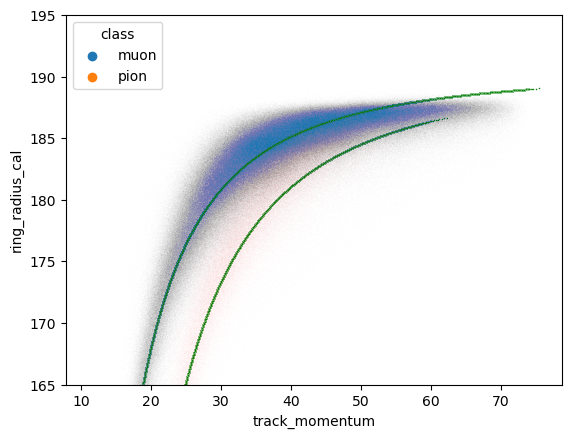

In [85]:
sns.scatterplot(data=selected_res, x='track_momentum', y='ring_radius_cal', color ='green', s=1)
g = sns.scatterplot(data=selected_res, x='track_momentum', y='radius_pred', s=1, hue='class', alpha=0.005)

g.set_ylim(165, 195)


In [95]:
selected_res['max_cal_diff'] = selected_res['ring_radius_cal'] - selected_res['ring_radius_cal'].max()

In [96]:
selected_res

,level_0,index,ring_radius_cal,ring_radius,track_momentum,radius_pred,res_pred,class,hit_distance_max,max_cal_diff
0,0,0,173.410156,172.410950,22.761024,169.586060,3.824097,muon,202.388535,-15.624924
1,1,1,174.660522,175.251694,23.600529,175.193893,-0.533371,muon,203.931854,-14.374557
2,2,2,155.299332,155.040802,16.275131,152.914215,2.385117,muon,175.765656,-33.735748
3,3,3,184.035400,185.832642,36.436443,183.525528,0.509872,muon,188.491943,-4.999680
4,4,4,156.473602,158.641846,16.525362,163.106735,-6.633133,muon,194.460358,-32.561478
...,...,...,...,...,...,...,...,...,...,...
2369110,2369110,2376022,174.585281,175.371704,31.104301,174.247910,0.337372,pion,218.202194,-14.449799
2369111,2369111,2376023,176.125702,178.343094,32.657063,183.080414,-6.954712,pion,364.990723,-12.909378
2369112,2369112,2376024,148.410736,148.395798,19.860395,150.537720,-2.126984,pion,167.444702,-40.624344
2369113,2369113,2376025,172.438187,175.335617,29.285913,169.730667,2.707520,pion,175.494507,-16.596893


### Plot showing residual and `max_cal_diff`
- `max_cal_diff` is calculated by subtracting the maximum `ring_radius_cal` value from `ring_radius_cal` (indicated as red line)

Text(0, 0.5, 'Residuals')

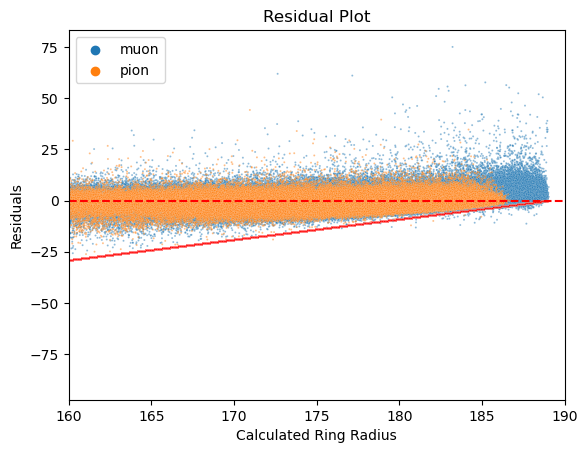

In [105]:
sns.scatterplot(data=selected_res, x='ring_radius_cal', y='res_pred', s=2, alpha = 0.5, hue='class')
g = sns.scatterplot(data=selected_res, x='ring_radius_cal', y='max_cal_diff', s=1, color='red', alpha=0.2)
plt.axhline(y=0, color='red', linestyle='--')
g.set_xlim(160, 190)
plt.title('Residual Plot')
plt.xlabel('Calculated Ring Radius')
plt.ylabel('Residuals')

In [98]:
selected_res['radius_pred'].max()

198.97789

In [99]:
selected_res['ring_radius_cal'].max()

189.03508

In [111]:
selected_res.query('max_cal_diff > res_pred')

,level_0,index,ring_radius_cal,ring_radius,track_momentum,radius_pred,res_pred,class,hit_distance_max,max_cal_diff
4228,4228,4239,186.879379,188.968109,48.432182,189.645889,-2.766510,muon,213.060989,-2.155701
9262,9262,9283,185.669327,186.356827,42.032219,191.447693,-5.778366,muon,223.835342,-3.365753
16516,16516,16552,187.360703,190.326782,51.952915,189.114090,-1.753387,muon,239.619110,-1.674377
23633,23633,23682,183.909149,185.923599,36.093182,191.313049,-7.403900,muon,223.855759,-5.125931
29483,29483,29547,186.228256,188.465195,44.649750,189.291031,-3.062775,muon,209.055298,-2.806824
...,...,...,...,...,...,...,...,...,...,...
2303894,2303894,2310484,183.937164,185.426041,47.776230,191.085083,-7.147919,pion,210.128372,-5.097916
2318753,2318753,2325420,182.053467,184.993423,42.236938,192.016891,-9.963425,pion,224.130157,-6.981613
2324284,2324284,2330985,179.331070,181.440186,36.878216,189.246902,-9.915833,pion,211.355042,-9.704010
2362622,2362622,2369507,185.002411,188.649689,52.107384,189.643173,-4.640762,pion,189.349289,-4.032669


#### Using only `hit_distance_q75` as feature

In [217]:
X_train_75 = X_train['hit_distance_q75']
X_test_75 = X_test['hit_distance_q75']

In [218]:
xgb_reg.fit(X_train_75, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [220]:
ypred_75 = xgb_reg.predict(X_test_75)

In [221]:
pred_75_df = pd.DataFrame(ypred_75, y_test).reset_index()
pred_75_df.columns=['theoretical_radius', 'predicted_radius']

In [222]:
pred_75_df['residual'] = pred_75_df['theoretical_radius'] - pred_75_df['predicted_radius']

Text(0, 0.5, 'Residuals')

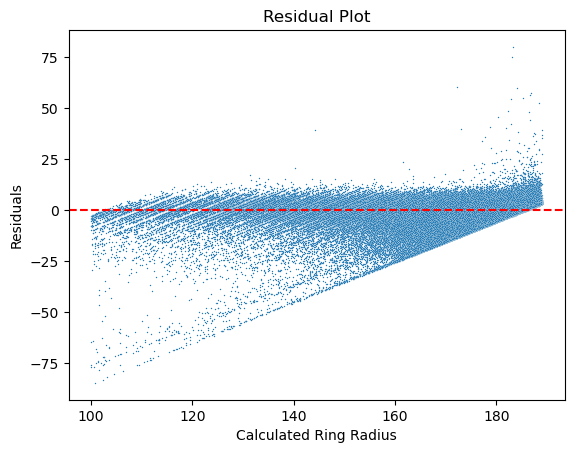

In [223]:
sns.scatterplot(data=pred_75_df, x='theoretical_radius', y='residual', s=1)
plt.axhline(y=0, color='red', linestyle='--')

plt.title('Residual Plot')
plt.xlabel('Calculated Ring Radius')
plt.ylabel('Residuals')

Text(0, 0.5, 'Residuals')

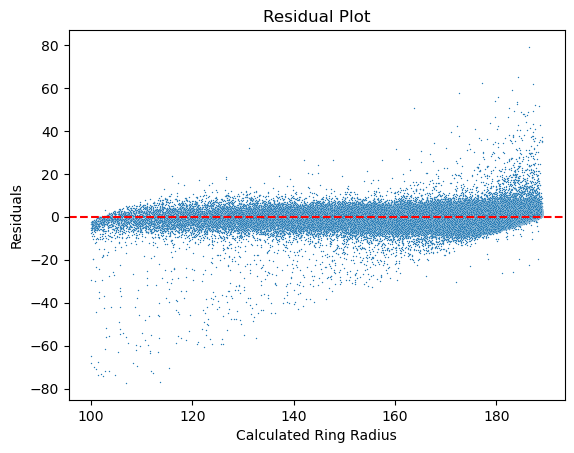

In [224]:
sns.scatterplot(data=pred_df, x='theoretical_radius', y='residual', s=1)
plt.axhline(y=0, color='red', linestyle='--')

plt.title('Residual Plot')
plt.xlabel('Calculated Ring Radius')
plt.ylabel('Residuals')

#### Using only `hit_distance_mean` as feature

In [225]:
X_train_mean = X_train['hit_distance_mean']
X_test_mean = X_test['hit_distance_mean']

In [227]:
xgb_reg.fit(X_train_mean, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [228]:
ypred_mean = xgb_reg.predict(X_test_mean)

In [229]:
pred_mean_df = pd.DataFrame(ypred_mean, y_test).reset_index()
pred_mean_df.columns=['theoretical_radius', 'predicted_radius']

In [230]:
pred_mean_df['residual'] = pred_mean_df['theoretical_radius'] - pred_mean_df['predicted_radius']

Text(0, 0.5, 'Residuals')

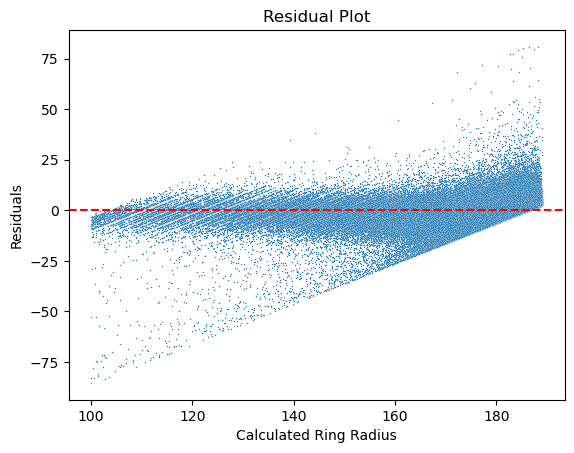

In [231]:
sns.scatterplot(data=pred_mean_df, x='theoretical_radius', y='residual', s=1)
plt.axhline(y=0, color='red', linestyle='--')

plt.title('Residual Plot')
plt.xlabel('Calculated Ring Radius')
plt.ylabel('Residuals')

### Conclusion:

- The ring radius is underestimated for larger values 
- The most important feature, hit_distance_median, starts to underestimate the prediction for radius over 180 mm
- This effect seems to be attributed to the upper limit of max calculated radius (~ 189 mm)  
